In [319]:
import ipynb
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import scipy.constants as consts
import lmfit
from pylcp.common import progressBar
import ast
import csv
import pickle
from scipy.optimize import bisect
from tqdm import tqdm
from ipynb.fs.full.MagnetsInterpolation import ComsolMagCylindricalInterpolation_au as mi
import inspect
from matplotlib.ticker import MultipleLocator

plt.ion()

loadpath = "./csv/"
savepath = "./images/"

# #laser parameters
# laser_det = -2
# ham_det = 0
# #laser power in Watts
# laser_power = 0.1
# #beam intensity 1/e^2 radius in cm
# beamWidth = 0.4
# #saturation intensity in W/cm^2
# Isat = 1
# s = laser_power/(Isat*np.pi*beamWidth**2)

import matplotlib as mpl

rcparams = {
# 'axes.titlesize'    : 18,
# 'axes.labelsize'    : 16,
# 'xtick.labelsize'   : 12,
# 'ytick.labelsize'   : 12,
# 'legend.fontsize'   : 12,
'font.size'         : 20
}
for e in rcparams.keys():
    mpl.rcParams[e] = rcparams[e]


hbar = consts.hbar
h = consts.h


k = 43692.384 # cm^-1
Gamma = 2*np.pi*99.7e6
hertz_unit = Gamma
# hertz_unit = 91e6
time_unit = 1/hertz_unit
m_unit = 1e-2/k
cm_unit = 100*m_unit
# time_unit = k*1e-2/hertz_unit # Needed due to the two ways units are measured

amu_const = consts.value('atomic mass constant')
velocity_unit = (m_unit/time_unit)
a_unit = (m_unit/time_unit**2)

E_unit = hbar/time_unit
F_unit = E_unit/m_unit
mass_unit = F_unit/a_unit

amu_unit = mass_unit/amu_const
Tesla_unit = hertz_unit/consts.value('Bohr magneton in Hz/T')

#scaled mass as described in the examples, for 114 Cd
# scaledMass = 4.87e-3
# print(scaledMass)
# scaledMass = 113.9*amu_const*hertz_unit/(hbar*k**2)
# mass_unit = velocity_unit/time_unit/(h*k*hertz_unit)
# print(scaledMass)
# amu_unit = 113.90336500/scaledMass
# amu_unit = 1/(amu_const*hertz_unit/(hbar*k**2))

# laser parameters from Simon
slower_beam_width = 0.5/2/cm_unit # cm
slower_I = 0.04 #0.3 # W/cm^2
slower_detuning = 0 # Placeholder
MOT_detuning = -1.45*100e6/hertz_unit
MOT_beam_width = 0.4/2/cm_unit # cm
Isat = 1.1
slower_s = 2*slower_I/(np.pi*(slower_beam_width**2))/Isat
# slower_s = 0.3

# read in initial vel_dist
vel_dist_raw_data = np.loadtxt("./csv/ChirpedSlowing_112_initialDistribution.dat")
vel_dist_raw_data = vel_dist_raw_data[vel_dist_raw_data[:,1].argsort()]

vel_dist_data = np.array([[i/velocity_unit,np.sum(vel_dist_raw_data[:,2], where=vel_dist_raw_data[:,1] == i)] for i in np.unique(vel_dist_raw_data[:,1])])
vel_dist = lambda x : np.interp(x, *(vel_dist_data.T))

# Some parameters for the MOT
# Mass taken from IAEA
mass = {106 : 105.9064598/amu_unit, 108 : 107.9041836/amu_unit, 110 : 109.9030075/amu_unit, 111 : 110.9041838/amu_unit, 112 : 111.90276390/amu_unit, 113 : 112.90440811/amu_unit, 114 : 113.90336500/amu_unit, 116 : 115.90476323/amu_unit}
abundance_data = {106 : 0.0125, 108 : 0.0089, 110 : 0.1249, 111 : 0.1280, 112 : 0.2413, 113 : 0.1222, 114 : 0.2873, 116 : 0.0749}

# Take isotope shift data from here: https://arxiv.org/pdf/2210.11425.pdf [Table II, this work]
isotope_shifts = {106 : 1818.1e6/hertz_unit, 108 : 1336.5e6/hertz_unit, 110 : 865e6/hertz_unit, 111 : 805.0e6/hertz_unit, 112 : 407.5e6/hertz_unit, 113 : 344.9e6/hertz_unit, 114 : 0e6/hertz_unit, 116 : -316.1e6/hertz_unit}
isotope_shift_hyperfine = {111 : (899.2e6 - 616.5e6)/hertz_unit, 113 : (443.4e6 - 147.8e6)/hertz_unit}

# Hamiltonians
ham_det = 0

def gen_Boson_Hamiltonian(isotope = 114):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
    return pylcp.hamiltonian(Hg, He + (isotope_shifts[isotope] - ham_det)*np.eye(3), Bgq, Beq, dijq,mass=mass[isotope],k=(k*cm_unit), gamma=(Gamma*time_unit),muB=1)

def gen_Fermion_Hamiltonian(isotope = 111):
    #Hamiltonian for F=1/2 -> F = 1/2,3/2 
    HgFermion, BgqFermion = pylcp.hamiltonians.hyperfine_coupled(J=0, I=1/2, gJ=0, gI=0, Ahfs=0, Bhfs=0, Chfs=0, muB=1)
    # HeFermion, BeqFermion = pylcp.hamiltonians.hyperfine_coupled(J=1, I=1/2, gJ=1, gI=0, Ahfs=2.2, Bhfs=0, Chfs=0, muB=1)
    Ahfs = 2*isotope_shift_hyperfine[isotope]/3
    HeFermion, BeqFermion = pylcp.hamiltonians.hyperfine_coupled(J=1, I=1/2, gJ=1, gI=0, Ahfs=Ahfs, Bhfs=0, Chfs=0, muB=1)
    dijqFermion = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(J=0, Jp=1, I=0.5)
    return pylcp.hamiltonian(HgFermion, HeFermion + (isotope_shifts[isotope] - ham_det)*np.eye(6), BgqFermion, BeqFermion, dijqFermion,mass=mass[isotope],k=1, gamma=1,muB=1)

Hamiltonians = {}
# Generate all Hamiltonians
for key in mass.keys():
    if (key in isotope_shift_hyperfine.keys()):
        Hamiltonians[key] = gen_Fermion_Hamiltonian(key)
        continue
    Hamiltonians[key] = gen_Boson_Hamiltonian(key)

permMagnets=mi('./csv/2D_Br_updated_30mmbore.csv', './csv/2D_Bz_updated_30mmbore.csv',Tesla_unit,cm_unit,-1)
permMagnetsStrong=mi('./csv/2D_Br.csv', './csv/2D_Bz.csv',Tesla_unit,cm_unit,-1)
permMagnetsPylcp = pylcp.magField(permMagnets.fieldCartesian)
permMagnetsPylcpStrong = pylcp.magField(permMagnetsStrong.fieldCartesian)

magnet_data = np.loadtxt("./csv/RingMagnet_BzProfile.csv",delimiter="\t")
def get_interpolator(pos):
    def interpolate_magnet(R):
        nonlocal pos
        R = R - pos
        x = abs(R[0])*cm_unit
        prevpos = None
        prevB = None
        
        for p, Bz in magnet_data:
            if(x < p):
                break
            prevpos = p
            prevB = Bz
        else:
            return [0,0,0]

        if prevpos is None:
            return [0,0,0]

        B = prevB + (x - prevpos)*(Bz - prevB)/(p - prevpos)
        
        B = B*10**(-4)/Tesla_unit

        return [B,0,0]
    return interpolate_magnet
slower_magnet = pylcp.magField(get_interpolator([0/cm_unit,0,0]))

In [320]:
det_MOT = -175/hertz_unit + isotope_shifts[112]
MOT_s = 1.5/Isat/6
MOT_s_total = 3/Isat
# MOT_s_total = 2/Isat
# MOT_s_total = 2.2/Isat
MOT_s_z = MOT_s_total*0.2/(0.67*2.6 + 0.20*1.5)
MOT_s_xy = MOT_s_total*0.67/(0.67*2.6 + 0.20*1.5)

MOT_s_xy = MOT_s
MOT_s_z = MOT_s

MOT_beams = pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':det_MOT, 's':MOT_s_xy,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':det_MOT, 's':MOT_s_xy,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':det_MOT, 's':MOT_s_xy,'wb':MOT_beam_width},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':det_MOT, 's':MOT_s_xy,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':det_MOT, 's':MOT_s_z,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':det_MOT, 's':MOT_s_z,'wb':MOT_beam_width}
    ], beam_type=pylcp.gaussianBeam)

In [321]:

eq = pylcp.rateeq(MOT_beams,permMagnetsPylcp, Hamiltonians[112],include_mag_forces=False)

i = 0
t_eval = np.arange(0e-6/time_unit,5e-3/time_unit, 5e-4/time_unit)
def run():
    global i
    i += 1
    print(i,end='\r')
    atol = [1]*4
    try:
        eq.set_initial_pop(np.array([1,0,0,0]))
    except ValueError:
        eq.set_initial_pop(np.array([0.5,0.5,0,0,0,0,0,0]))
        atol = [1e-2]*6
    eq.set_initial_position_and_velocity(np.array([-0.02/cm_unit,0,0]),np.array([-4/velocity_unit,0/velocity_unit,-0/velocity_unit]))
    [atol.append(10/cm_unit) for _ in range(3)]
    [atol.append(10/velocity_unit) for _ in range(3)]
    return eq.evolve_motion([0., 3e-3/time_unit], t_eval = t_eval,
                      max_step=5e-3/time_unit,progress_bar=True,random_recoil=False, atol = atol)

r = run()

r_avg = np.mean(np.array([r.r]), axis= 0)

ValueError: Values in `t_eval` are not within `t_span`.

In [322]:
plt.ion()
plt.figure()
plt.plot(r.t*time_unit*1e3, r_avg[0]*cm_unit,'rx-')
plt.grid()
plt.show()
plt.figure()
plt.plot(t_eval*time_unit*1e3, r_avg[1]*cm_unit,'gx-')
plt.plot(t_eval*time_unit*1e3, r_avg[2]*10*cm_unit,'bx-')
plt.grid()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 't'

<Figure size 640x480 with 0 Axes>

In [323]:
dr = 0.1/cm_unit
dv = 1/velocity_unit

r = np.arange(-15.1/cm_unit, +15.1/cm_unit+dr, 2*dr)
v = np.arange(0, 200/velocity_unit, 2*dv)

R, V = np.meshgrid(r, v)

def Slow_Beam(det_slower, *args, **kwargs):
    # pol /= sum(map(lambda x : x*np.conj(x), pol))
    return pylcp.laserBeams([
        {'kvec':np.array([-1, 0., 0.]), 'pol': -1, 'delta':det_slower, 's':slower_s,'wb':slower_beam_width, 'pol_coord':'spherical'}
    ], beam_type=pylcp.gaussianBeam)

laserargs = {'det_slower' : -750e6/hertz_unit}
eq = pylcp.rateeq(Slow_Beam(**laserargs),permMagnetsPylcp, Hamiltonians[114],include_mag_forces=True,)
eq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)



Completed in 10.04 s.                                               


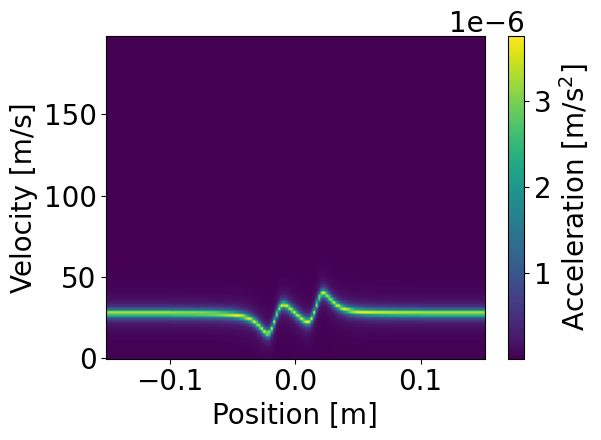

In [324]:

fig, ax = plt.subplots()
im = ax.imshow(-1*eq.profile['Frad'].F[0]*F_unit/(mass[114]*mass_unit), origin='lower',
           extent=(np.amin(r)*m_unit, np.amax(r)*m_unit,
                   np.amin(v*velocity_unit)-dv/2, np.amax(v*velocity_unit)-dv/2),
           aspect='auto', cmap='viridis')
# plt.text(-0.24,390, "$\Delta = -8.7\\;\\Gamma$\n$I = 0.3\\;I_{sat}$", verticalalignment='top', color='w')
ax.set_xlabel("Position [m]")
ax.set_ylabel("Velocity [m/s]")
cb1 = plt.colorbar(im)
cb1.set_label("Acceleration [m/s$^2$]")
plt.tight_layout()
plt.show()

In [159]:
permMagnetsPylcp.Field((-0.15,0,0))

TypeError: can't multiply sequence by non-int of type 'float'

In [30]:
k*m_unit

6.283185307179586

In [305]:
dir(Hamiltonians[114])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_hamiltonian__add_new_row_and_column',
 '_hamiltonian__check_diagonal_submatrices_are_themselves_diagonal',
 '_hamiltonian__make_elem_label',
 '_hamiltonian__recompute_number_of_states',
 '_hamiltonian__search_elem_label',
 'add_H_0_block',
 'add_d_q_block',
 'add_mu_q_block',
 'block',
 'blocks',
 'diag_H_0',
 'diag_static_field',
 'diagonal',
 'laser_keys',
 'make_full_matrices',
 'mass',
 'n',
 'ns',
 'print_structure',
 'return_full_H',
 'set_mass',
 'state_labels',
 'vector_block']